# Analyse d'un dataframe de vol - Amélioration du modèle

Projet de statistiques descriptives MACS3, dans le cadre du cours de Jérôme Lacaille.

_Version 1.0 [28/11/2023] Kraemer Valentin_

## Analyse de notre problématique d'inclinaison de l'avion en fonction de l'angle du levier - cas d'un seul vol

Petite partie intermédiaire d'amélioration du modèle à l'aide de variables de contexte.

**Importation des modules pour l'analyse**

In [1]:
%reload_ext autoreload
%autoreload 2

# module
import sys
sys.path.append("../")
from src import *

### Récupération de la donnée

In [2]:
# chemin vers la donnee 
data_dir = '/home/valentin/Documents/Cours/MACS/MACS3/madane/data/data_extracted/'
filelist = glob.glob(data_dir + '*.h5')

# PARAMETRES DE LA DONNEE 
# Avion
_PLANE = 0

# fonction de lecture de fichier .h5, realise lors des TD d'A.Madane
ddf = lire_hdf_dask(filelist[_PLANE], repertoire= data_dir)

# VOL
_VOL = 0 

# RECUPERATION DU DATAFRAME 
df = ddf.partitions[_VOL].compute()

Ce HDFStore n'est pas partitionnable et ne peut être utilisé de manière monolithique qu'avec pandas.
Création d'un nouveau fichier de données: '/home/valentin/Documents/Cours/MACS/MACS3/madane/data/data_extracted/Aircraft_03_dask.h5'
Lecture du fichier de données: '/home/valentin/Documents/Cours/MACS/MACS3/madane/data/data_extracted/Aircraft_03_dask.h5'


### De nouvelles tentatives de modèle - perspective d'amélioration 

Dans le précédent notebook, on s'intéressait à la régression $\theta_{avion} ~ \theta{levier}$ et obtenions un $R^2$ de l'ordre de 0.4. Est-il possible d'ajouter des variables de contexte pour obtenir de meilleurs résultats de regression ?

**Quels sont les candidats possibles ?**

On retient deux candidats pour l'amélioation de ce modèle. Tout d'abord le temps de vol. Physiquement non interprétable, on peut néanmoins penser que celui-ci, définissant l'évolution des autres indicateurs, a une utilité dans l'amélioration du modèle. 

Ensuite, la vitesse des fans, pouvant directement influer sur le comportement de l'avion.

**Récupération du dataframe d'analyse**

Il suffit de modifier un tout petit peu la fonction angle_analysis présentée précedemment pour obtenir le dataframe d'analyse contenant les variables supplémentaires souhaitées.

In [9]:
def angle_analysis_v2(df, stick_range = [2,33], physical_range = [-18,18], params = None):
    """
    angle_analysis 

    desc : analyse de la relation linéaire entre l'angle des vitesses et l'angle du levier

    Input :
        df : dataframe d'un vol 
        stick_range (facultatif): range de validité du levier où celui-ci n'est pas bloqué
        physical_range (facultatif):  range pour laquelle les angles de l'avion par rapport à la verticale sont physiquement acceptables
        params : liste de paramètres à garder pour l'analyse

    Output : 

    """
    # acquisition des vitesses horizontales et verticales 
    df_speed = add_speed(df)

    # indices selectionnnes : il s'agit des instants durant lequels l'avion n'est pas immobile
    id_on_air =  df_speed['ON_AIR']
    id_stick_interval = (df_speed['TLA_1 [deg]']>stick_range[0]) * (df_speed['TLA_1 [deg]']<stick_range[1])
    id_study = id_on_air*id_stick_interval
    tps = df_speed[id_study].index.values

    # stockage des variables d'interet 
    vx = df_speed['dx [ft/s]'][id_study].values
    vy = df_speed['dy [ft/s]'][id_study].values 
    theta = np.arctan(vy/vx)*180/np.pi                      # converti en degres
    theta_levier = df_speed['TLA_1 [deg]'][id_study].values 

    # data_frame intermedaire 
    df_interm = pd.DataFrame({'theta_levier': theta_levier, 'theta_vitesse' : theta, 'vx': vx, 'vy':vy, 'time' :tps }).set_index('time')

    # ajout des variables d'interet
    if params !=None :
        for param in params :
            newname = re.sub(r' \[.*?\]', '', param)
            df_interm[newname] = df_speed[param][id_study].values


    id_physically_admitted = (df_interm['theta_vitesse']>physical_range[0])*(df_interm['theta_vitesse']<physical_range[1])

    # data_frame d'analyse
    df_study = df_interm[id_physically_admitted]

    return df_study

Ainsi, en ajoutant une liste de paramètres à garde pour l'analyse dans la liste params, on obtient le nouveau dataframe d'étude.

In [35]:
# ajouter les paramètres de votre choix, amusez vous ! 
params = ['N1_1 [% rpm]','N2_1 [% rpm]', 'ALT [ft]', 'T1_1 [deg C]']
df_study = angle_analysis_v2(df, params = params)
df_study

,theta_levier,theta_vitesse,vx,vy,N1_1,N2_1,ALT,T1_1
time,,,,,,,,
1214,32.894502,8.349490,379.103484,55.639687,107.200347,86.567566,5958.083104,17.652975
1215,32.176129,8.349490,379.103484,55.639687,102.271460,86.465532,6013.722791,17.536901
1216,32.488969,8.349490,379.103484,55.639687,102.565546,85.292138,6069.362477,17.536901
1217,32.488969,8.349490,379.103484,55.639687,103.000794,85.615246,6125.002164,17.536901
1218,32.593249,7.481989,388.349910,51.003046,102.930213,85.504709,6180.641850,17.411154
...,...,...,...,...,...,...,...,...
8393,21.388957,-2.610110,203.421381,-9.273281,73.086333,79.765282,454.390774,27.693407
8394,21.076118,-5.209432,203.421381,-18.546562,73.380419,79.875819,445.117493,27.809482
8395,20.473612,-4.984102,212.667808,-18.546562,73.380419,79.926836,426.570930,27.935229


In [37]:
# regression 
# formule de regression supposee
formula = 'theta_vitesse ~  theta_levier+ ALT  '

model = ols(data = df_study, formula = formula).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          theta_vitesse   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     2642.
Date:                Sun, 03 Dec 2023   Prob (F-statistic):               0.00
Time:                        16:23:45   Log-Likelihood:                -8105.0
No. Observations:                5678   AIC:                         1.622e+04
Df Residuals:                    5675   BIC:                         1.624e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.8802      0.081    -72.912      0.000      -6.038      -5.722
theta_levier     0.2581      0.004     65.431      0.000       0.250       0.266
ALT          -4.087e-05   1.84e-06    -22.237      0.000   -4.45e-05   -3.73e-05
==============================================================================
Omnibus:                     1821.095   Durbin-Watson:                   1.210
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           211874.179
Skew:                           0.480   Prob(JB):                         0.00
Kurtosis:                      32.910   Cond. No.                     2.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

On observe une légère amélioration (de 5 points) du modèle en ajoutant la variable d'altitude. C'est déjà pas mal va-t-on dire... Peu convaincu du résultat, nous proposons néanmoins d'afficher le nuage de point avec une colorbar d'altitude pour en tirer une quelconque information :

<AxesSubplot:xlabel='theta_vitesse', ylabel='theta_levier'>

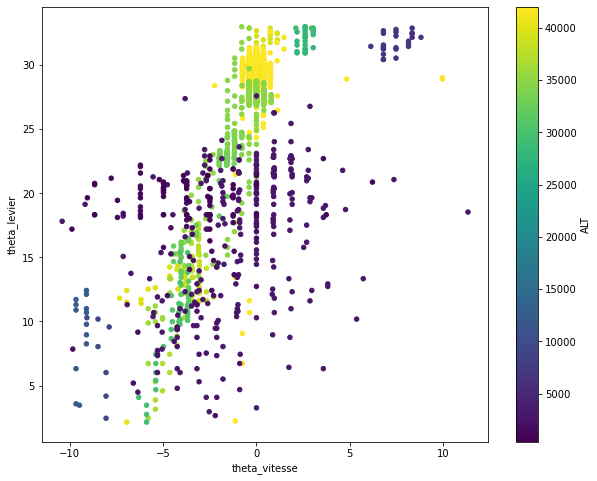

In [55]:
fig, ax = plt.subplots( figsize = (10,8))
df_study.plot.scatter('theta_vitesse', 'theta_levier',c = 'ALT', ax = ax)

Le résultat est clair maintenant : la dépendance entre les deux angles semble être linéaire à partir d'une certaine altitude.. Améliorons alors la fonction précedemment décrite.

In [58]:
def angle_analysis_v3(df, stick_range = [2,33], physical_range = [-18,18], params = None, alt_min = 10000):
    """
    angle_analysis 

    desc : analyse de la relation linéaire entre l'angle des vitesses et l'angle du levier

    Input :
        df : dataframe d'un vol 
        stick_range (facultatif): range de validité du levier où celui-ci n'est pas bloqué
        physical_range (facultatif):  range pour laquelle les angles de l'avion par rapport à la verticale sont physiquement acceptables
        params : liste de paramètres à garder pour l'analyse
        alt_min : altitude admise pour l'étude 

    Output : 

    """
    # acquisition des vitesses horizontales et verticales 
    df_speed = add_speed(df)

    # indices selectionnnes : il s'agit des instants durant lequels l'avion n'est pas immobile
    id_on_air =  df_speed['ON_AIR']
    id_stick_interval = (df_speed['TLA_1 [deg]']>stick_range[0]) * (df_speed['TLA_1 [deg]']<stick_range[1])
    id_study = id_on_air*id_stick_interval
    tps = df_speed[id_study].index.values

    # stockage des variables d'interet 
    vx = df_speed['dx [ft/s]'][id_study].values
    vy = df_speed['dy [ft/s]'][id_study].values 
    theta = np.arctan(vy/vx)*180/np.pi                      # converti en degres
    theta_levier = df_speed['TLA_1 [deg]'][id_study].values 

    # data_frame intermedaire 
    df_interm = pd.DataFrame({'theta_levier': theta_levier, 'theta_vitesse' : theta, 'vx': vx, 'vy':vy, 'time' :tps }).set_index('time')

    # ajout des variables d'interet
    if params !=None :
        for param in params :
            newname = re.sub(r' \[.*?\]', '', param)
            df_interm[newname] = df_speed[param][id_study].values


    id_physically_admitted = (df_interm['theta_vitesse']>physical_range[0])*(df_interm['theta_vitesse']<physical_range[1])
    id_alt_admitted = df_interm['ALT']>alt_min

    # data_frame d'analyse
    df_study = df_interm[id_alt_admitted*id_physically_admitted]

    return df_study

On teste alors notre nouvelle hypothèse dans la suite de ces codes :

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          theta_vitesse   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                 1.363e+04
Date:                Sun, 03 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:05:40   Log-Likelihood:                -3995.7
No. Observations:                5282   AIC:                             7995.
Df Residuals:                    5280   BIC:                             8008.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -6.8682      0.058   -118.890      0.000      -6.981      -6.755
theta_levier     0.2347      0.002    116.762      0.000       0.231       0.239
==============================================================================
Omnibus:                     3441.087   Durbin-Watson:                   0.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1405263.460
Skew:                           1.878   Prob(JB):                         0.00
Kurtosis:                      82.819   Cond. No.                         234.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

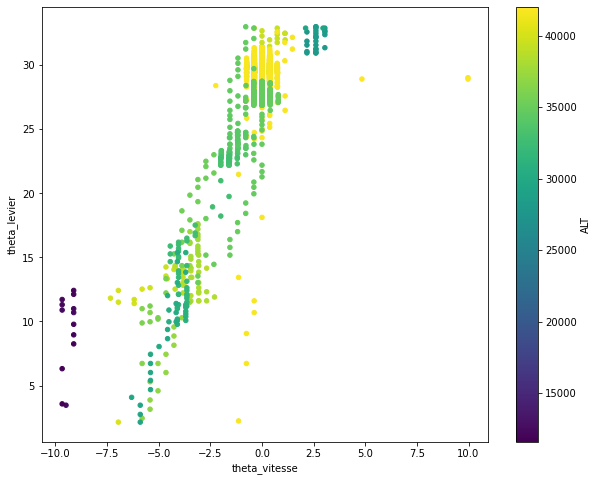

In [79]:
# ajouter les paramètres de votre choix, amusez vous ! 
params = ['N1_1 [% rpm]','N2_1 [% rpm]', 'ALT [ft]', 'T1_1 [deg C]']

# on impose une altitude minimale 
alt_min = 10000

# recuperation du dataframe de sortie 
df_study = angle_analysis_v3(df, params = params, alt_min=alt_min)

# affichage sous forme de nuage de points
fig, ax = plt.subplots( figsize = (10,8))
df_study.plot.scatter('theta_vitesse', 'theta_levier',c = 'ALT', ax = ax)

# regression 
# formule de regression supposee
formula = 'theta_vitesse ~  theta_levier  '

model = ols(data = df_study, formula = formula).fit()
model.summary()

On observe une franche amélioration des coefficients de regression, c'est clairement rassurant ! L'analyse de Félix s'interessera notamment à une méthode de clustering permettant de charcuter les données de manière moins arbitraire.

**Critique de la méthode**

Il est clair que cette méthode érode énormément la donnée et séléctionne une phase de vol ne correspondant ni à la montée, ni à la descente (phases supposées être les plus intéressantes compte tenu de l'importance des mouvements de levier lors de ces périodes de vols..)

Néanmoins, on constate de la forte dépendance entre l'inclinaison de l'avion et du levier lors des phases moins variables (pilote automatique ?)